## Automated Expense Extraction - Receipt Parsing Using YOLO and OCR
### Inference

In [1]:
# Install Dependencies
!pip install ultralytics pytesseract
# !sudo apt-get install tesseract-ocr


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import re
import os

In [3]:
# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    # Mount Google Drive (for Colab)
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Set DATA_PATH for Google Drive
    DATA_PATH = Path('/content/drive/MyDrive/data')
else:
    # Set DATA_PATH for local environment
    DATA_PATH = Path('../data')

In [4]:
# Load YOUR trained model

# model_path = DATA_PATH / "models/yolo_receipts/weights/best.pt"
# model_path = DATA_PATH / "models/yolo_receipts_small/weights/best.pt"
model_path = DATA_PATH / "models/yolo_receipts_highres_nano/weights/best.pt"
model = YOLO(model_path)

In [ ]:
# ADAPTIVE PREPROCESSING

def clean_crop_vendor(crop_img):
    """Gentle cleaning for Logos (Grayscale + Median Blur)"""
    if len(crop_img.shape) == 3: gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    else: gray = crop_img
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return cv2.medianBlur(gray, 3)

def clean_crop_numeric(crop_img):
    """Aggressive cleaning for Numbers (Adaptive Threshold)"""
    if len(crop_img.shape) == 3: gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    else: gray = crop_img
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 10)

def preprocess_full_page(original_img):
    """
    UNIVERSAL CLEANER: Handles both Scans (SROIE) and Mobile Photos.
    1. Removes Scanner Borders.
    2. Adaptive Thresholding (Best for text).
    """
    # 1. Convert to Gray
    if len(original_img.shape) == 3:
        gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = original_img

    # 2. Resize (Standardize)
    h, w = gray.shape
    scale = 1000 / h
    gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    # 3. Gaussian Blur (Kill sensor noise)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Morphological Open (Remove thin lines/noise)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    # 5. Adaptive Thresholding (The Robust Standard)
    # We use a large block size (31) to handle shadows if they exist,
    # but it works perfectly on flat white scans too.
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31, 10
    )

    # 6. BORDER REMOVAL (Crucial for Scans)
    # Finds the largest connected component (the receipt) and blacks out the rest
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_cnt = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(thresh)
        cv2.drawContours(mask, [largest_cnt], -1, 255, -1)
        # Apply mask: Keep only the receipt, make everything else white
        result = cv2.bitwise_and(thresh, thresh, mask=mask)
        # Invert mask to make background white (Tesseract loves white backgrounds)
        background = cv2.bitwise_not(mask)
        result = cv2.add(result, background)
        return result

    return thresh

In [6]:
# UNIVERSAL FALLBACK LOGIC

def fallback_find_total(text):
    """
    Finds currency.
    IMPROVEMENT: Uses \b to force stop after 2 decimals.
    Handles 9.00, 1,200.50, 9,00 (European style)
    """
    # Regex:
    # \d{1,3}       -> 1 to 3 digits
    # (?:[.,]\d{3})* -> Optional thousands separators
    # [.,]          -> Decimal point (dot or comma)
    # \d{2}         -> EXACTLY two decimals
    # \b            -> Word boundary (Stops 9.006 from becoming 9.006)
    pattern = r'(\d{1,3}(?:[.,]\d{3})*[.,]\d{2})\b'

    matches = re.findall(pattern, text)
    if not matches: return None

    try:
        # Clean standard: replace , with . if it looks like a decimal
        # Heuristic: The largest number is usually the Total
        clean_values = []
        for m in matches:
            # Normalize 1,200.00 -> 1200.00
            # Normalize 9,00 -> 9.00
            val = m.replace(',', '.')
            # Fix double dots if any
            if val.count('.') > 1: val = val.replace('.', '', val.count('.')-1)
            clean_values.append(float(val))

        return "{:.2f}".format(max(clean_values))
    except:
        return matches[-1]

def fallback_find_vendor(text):
    """
    Heuristic: Vendor is the first SIGNIFICANT line.
    IMPROVEMENT: Skips lines that are too short (< 4 chars).
    """
    # Split into lines and remove empty ones
    lines = [line.strip() for line in text.split('\n') if len(line.strip()) > 0]

    blacklist = ["welcome", "receipt", "tax invoice", "gst", "tel", "fax", "website", "email"]

    for line in lines[:6]: # Check top 6 lines
        # Rule 1: Must be longer than 3 chars ("NH" -> Skip)
        if len(line) < 4: continue

        # Rule 2: Must not contain blacklist words
        if not any(b in line.lower() for b in blacklist):
            # Rule 3: Must generally look like a name (mostly letters)
            # (Optional check to avoid pure numbers being picked as vendor)
            if any(c.isalpha() for c in line):
                return line
    return None

def get_full_page_text(original_img):
    """Debug wrapper for OCR"""
    print("   ⚠️ Running Full Page OCR Safety Net...")
    processed = preprocess_full_page(original_img)

    # DEBUG: See what the safety net sees!
    plt.figure(figsize=(6,6)); plt.imshow(processed, cmap='gray'); plt.title("Safety Net Input"); plt.show()

    text = pytesseract.image_to_string(processed, config='--psm 3')

    # DEBUG: Print the text to console so you can see why it failed
    # print(f"--- FULL PAGE TEXT DUMP ---\n{text}\n---------------------------")

    return text


def fallback_find_date(text):
    """Finds date patterns in full text"""
    # Matches: 25/12/2018, 2018-12-25, 25 DEC 2018
    pattern = r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2}|\d{1,2}\s(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)[a-z]*\s\d{2,4})'
    matches = re.findall(pattern, text, re.IGNORECASE)
    return matches[0] if matches else None


In [ ]:
# MAIN INFERENCE PIPELINE

def run_scanner(image_path):
    print(f"\n--- 📸 Scanning: {image_path.name} ---")

    # 1. VISUAL DETECTION (YOLO)
    results = model.predict(image_path, conf=0.10, verbose=False)
    result = results[0]
    original_img = cv2.imread(str(image_path))
    display_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_BGR2RGB)

    extracted_data = {}

    # 2. PROCESS YOLO HITS
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls_id = int(box.cls[0])
        label = model.names[cls_id]

        # Crop & Clean
        h, w, _ = original_img.shape
        crop = original_img[max(0, y1-5):min(h, y2+5), max(0, x1-5):min(w, x2+5)]
        if crop.size == 0: continue

        if label in ['company', 'vendor']:
            final_crop = clean_crop_vendor(crop)
            config = '--psm 6'
        else:
            final_crop = clean_crop_numeric(crop)
            config = '--psm 7 -c tessedit_char_whitelist=0123456789./:-RM'

        text = pytesseract.image_to_string(final_crop, config=config).strip()
        if label == 'total': text = text.replace("RP", "RM").replace("Rm", "RM")

        # Store (Keep first detection)
        if label not in extracted_data:
            extracted_data[label] = text

        # Visualization
        cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(display_img, f"{label}: {text}", (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # UNIVERSAL SAFETY NET (Check ALL fields)
    required_fields = ['vendor', 'date', 'total']

    # Check if we are missing ANY field
    # (Note: YOLO might name vendor 'company', normalize this)
    if 'company' in extracted_data: extracted_data['vendor'] = extracted_data.pop('company')

    missing_fields = [f for f in required_fields if f not in extracted_data]

    if missing_fields:
        print(f"   ⚠️ Missing fields: {missing_fields}. Engaging Fallback...")

        # Run OCR ONCE on full page
        full_text = get_full_page_text(original_img)
        print(full_text)

        if 'date' in missing_fields:
            val = fallback_find_date(full_text)
            if val: extracted_data['date'] = val

        if 'total' in missing_fields:
            val = fallback_find_total(full_text)
            if val: extracted_data['total'] = val

        if 'vendor' in missing_fields:
            val = fallback_find_vendor(full_text)
            if val: extracted_data['vendor'] = val

    # 4. DISPLAY
    plt.figure(figsize=(10, 10))
    plt.imshow(display_img)
    plt.axis('off')
    plt.title("YOLO + Hybrid Fallback", fontsize=14)
    plt.show()

    print("\n--- 🧾 EXTRACTED DATA ---")
    for k, v in extracted_data.items():
        print(f"  {k.upper()}: {v}")
    print("-" * 30)


--- 📸 Scanning: X51005663300.jpg ---
   ⚠️ Missing fields: ['date']. Engaging Fallback...
   ⚠️ Running Full Page OCR Safety Net...


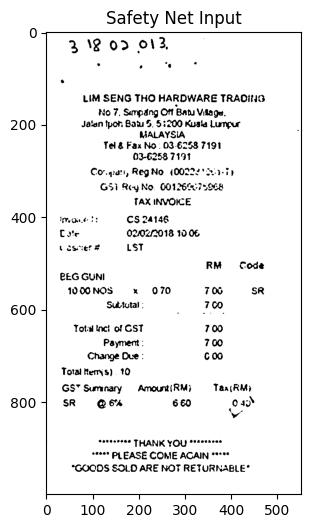

312 0d 013,

. . «

LIM SENG THO HARDWARE TRADING

No 7, Sunpang Off Batu Vilage,
Jalan tpors Batu 5, 53200 Kuala Lumpur

MALAYSIA

Tel & Fax No: 03-6258 7191

03-6258 7191
Co.man, RegNo (00222 ' 2.4.
G57 Rey No. C0126 75068

TAX INVOICE
Inoue Tt CS 24146
Tote 0202/2018 10 06
vosver# LST
RM Code
BEG GUNI
1000 NOS x 070 70 sR
‘Subtotal : 70
Total tinct of GST 700
Payment : 700
Change Due : ¢00
Total terms). 10
GS* Summary = AmountiRM} Taa(RM)
SR @6% 660 oa
ww

seeeeeeee THANK YOU fee
PLEASE COME ACAIN ***°*
“GOODS SOLD ARE NOT RETURNABLE®




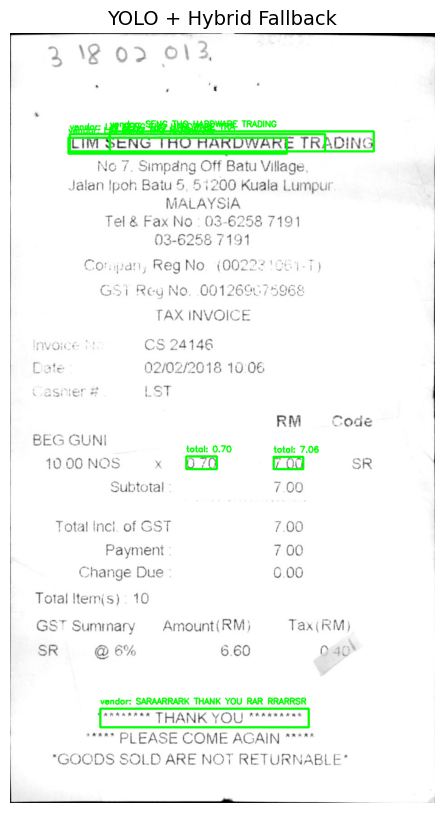


--- 🧾 EXTRACTED DATA ---
  VENDOR: LIM SENG THO HARDWARE
  TOTAL: 7.06
------------------------------

--- 📸 Scanning: X51006619842.jpg ---
   ⚠️ Missing fields: ['date']. Engaging Fallback...
   ⚠️ Running Full Page OCR Safety Net...


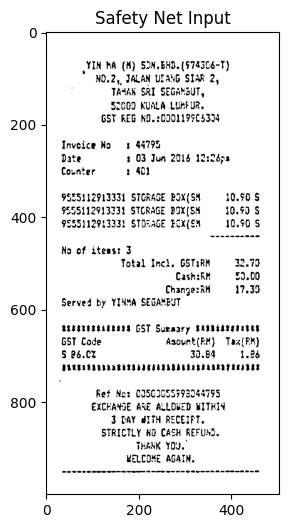

GYIM KA (HM) SON,BHD. (978366-T}
NO.2,, JALAN UTANG SIAR 2,
TAMAN SRI SEGAMBUT,
52000 KUALA LURFUR.

GST REG ND. 20901195C5308

Invoice Hos 44795
Date 303 Jun 2016 12s2épa
Counter 2 401

GSESILZPUTS3L STGRASE BOX(SH 10.90.
GSS5112913231 STORAGE BOX(SH 10.99 §
PESSI2913331 STORAGE ECX (EM 16.50 5
No of iteas: 3

Total Incl. GST3RM 32.79
Cashshh 59.00
Change:RH 17,39

Served by YINMA SEGAMEUT

RURGRENAANEATT GST Surmary EAMDSaT EET ES
GST Code Asownt(FM}  Tax(PM)
§ 84.0% 30,84 1.86
PASECESLISULStIVOLisciceiicreseitisesn ics

Ref Nez CISCIOSS#93049795
EXCEANSE ARE ALLOWED WITHIN
3 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND.
THAKK YOU.”

BELCOME AGAIN.



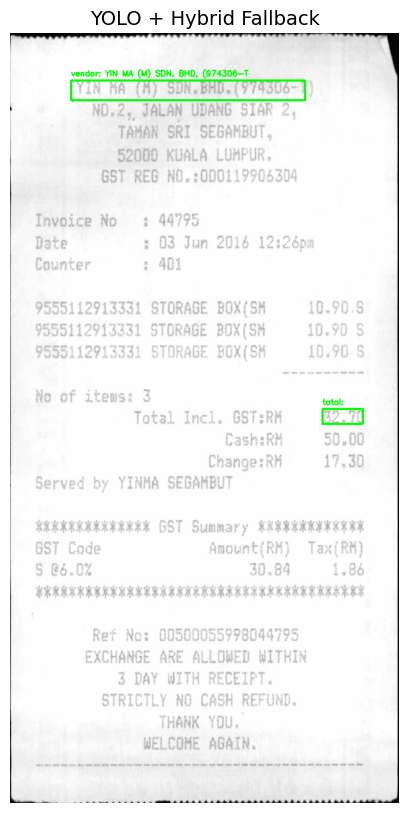


--- 🧾 EXTRACTED DATA ---
  TOTAL: 
  VENDOR: YIN MA (M) SDN. BHD, (974306-T
  DATE: 03 Jun 2016
------------------------------


In [8]:
# RUN TEST
test_dir = DATA_PATH / "raw/SROIE2019/test/img"
files = list(test_dir.glob("*.jpg"))[:2]
for f in files: run_scanner(f)


--- 📸 Scanning: IMG_8484 2.jpg ---
   ⚠️ Missing fields: ['vendor', 'date', 'total']. Engaging Fallback...
   ⚠️ Running Full Page OCR Safety Net...


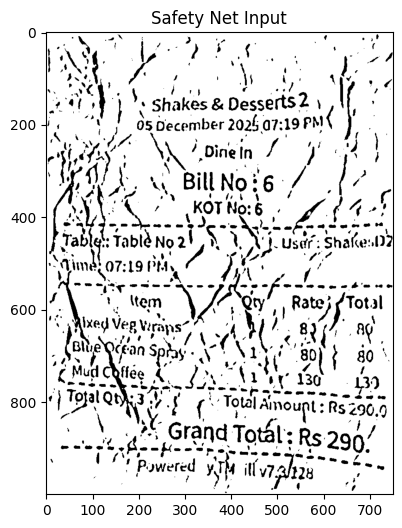

Shakes & . Desserts? \

05 December 2024 a7: 19 pat
. oe \\ iti f yooh
q \s, BilLNO 6 / | -
Kor Noré (4-5

a vata we ‘}. UsiF: bh 02
my L
‘aim 07: 19t My Wh

Ce oe ad ad hed sian Relirtintate

?

“

0

4 ttem Me Fate wa
xed Venn, AU ‘ BY!

ate an \
Ld CRffee x ie “a Me 13a 139

nt Sate.
fale, aor halal ebay cay See

ci re {" “Total Amount: 5 290.0

ae Grand Total’: Rs 230/

weet oot pee

a "
' Powered vy ill saighs ie



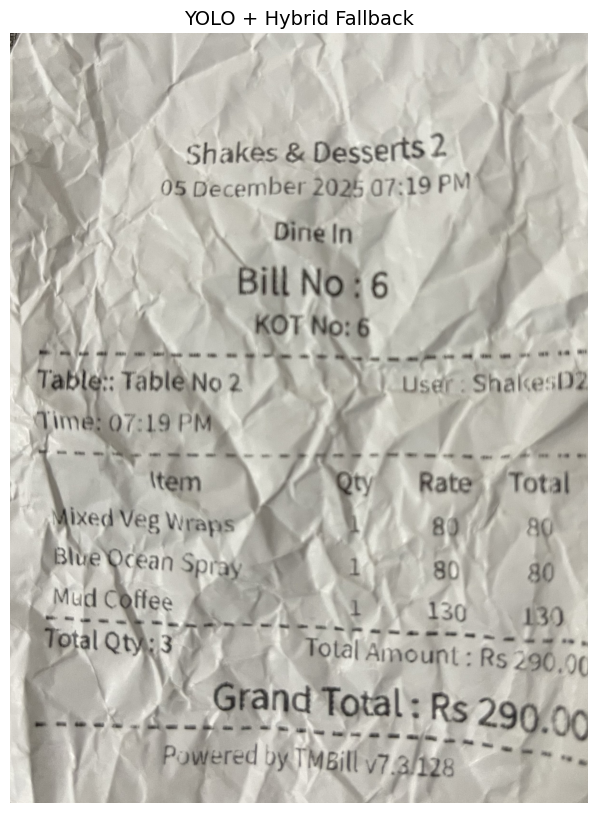


--- 🧾 EXTRACTED DATA ---
  DATE: 05 December 2024
  VENDOR: Shakes & . Desserts? \
------------------------------

--- 📸 Scanning: test_1.jpg ---
   ⚠️ Missing fields: ['date', 'total']. Engaging Fallback...
   ⚠️ Running Full Page OCR Safety Net...


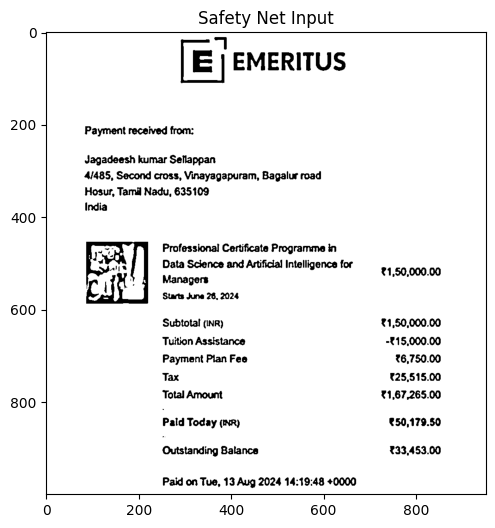

7
[E| EMERITUS

Payment received from:

Jagadeesh kumar Sellappan

4/485, Second cross, Vinayagapuram, Bagalur road
Hosur, Tami Nadu, 635109

India

Professional Certificate Programme in
Data Science and Artificial Intelligence for
Managers

Stata June 26, 2024

Subtotal (INR)
Tuition Assistance
Payment Plan Fee
Tax

Total Amount

Pald Today (mr)

Outstanding Balance

Paid on Tue, 13 Aug 2024 14:19:48 +0000

%1,50,000.00

%1,50,000.00
15,000.00
26,750.00
25,515.00
%1,67,265.00

€50,179.50

233,453.00



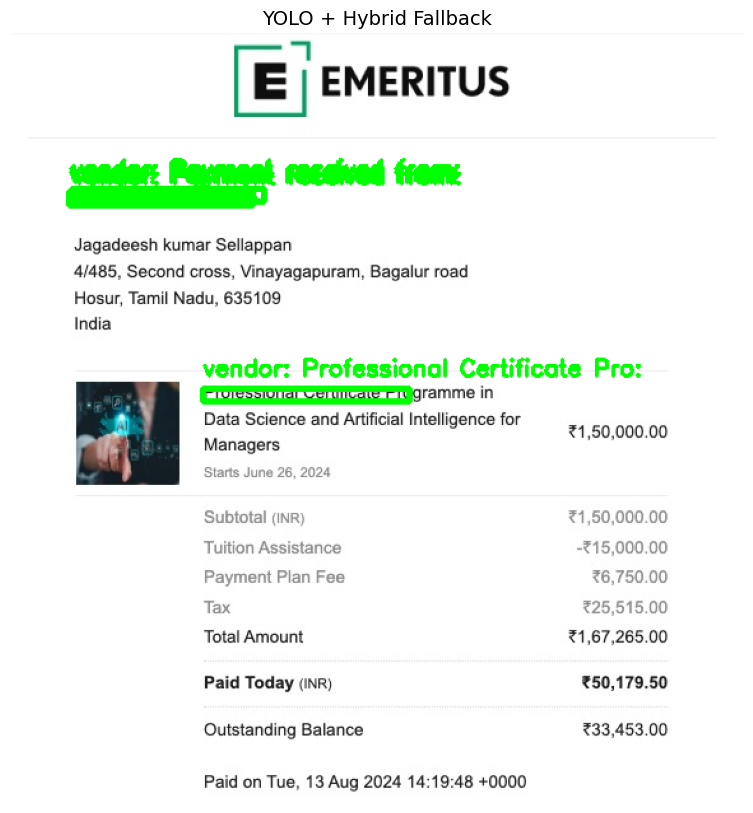


--- 🧾 EXTRACTED DATA ---
  VENDOR: Payment received from:
  DATE: 13 Aug 2024
  TOTAL: 233453.00
------------------------------


In [11]:
# RUN TEST
test_dir = DATA_PATH / "own"
files = list(test_dir.glob("*.jpg"))[:4]
for f in files: run_scanner(f)